<a href="https://colab.research.google.com/github/Dmtrvna/MML/blob/main/Pokemon_lab_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Анализ слабостей покемонов 1-2 поколений**


---



Датасет "Статистика и типы покемонов: индекс 1–2-го поколений"
Ссылка на датасет: https://www.kaggle.com/datasets/nudratabbas/pokmon-stats-and-types-generation-1-2-index

Этот набор данных содержит базовую статистику по первым 250 покемонам.

Набор данных включает в себя:

Идентификация: Идентификатор и имя в покедексе.

Физические характеристики: Рост и вес.

Боевые характеристики: ОЗ, атака, защита, специальная атака, специальная защита и скорость, опыт за победу.

Классификация: Основные и второстепенные типы.

Размерность: Датасет содержит 250 строк и 13 признаков.

Типы признаков:

Категориальные (object): Name (Имя), Primary Type (Основной тип), Secondary Type (Дополнительный тип).

Целочисленные (int64): Pokedex ID (ID в Покедексе), HP (Очки здоровья), Attack (Атака), Defense (Защита), Sp. Atk (Спец. Атака), Sp. Def (Спец. Защита), Speed (Скорость), Height (Рост), Weight (Вес), Base Experience(Опыт).

Вещественные (float64): Признаков такого типа в базовом наборе нет. Числовые признаки представлены целыми числами.

In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report,
    confusion_matrix, mean_absolute_error, mean_squared_error, r2_score
)
from sklearn.linear_model import LogisticRegression, Ridge  # ← ЭТО
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.impute import SimpleImputer

import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Загрузка датасета
df = pd.read_csv("/content/pokemon_stats_2025.csv")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   pokedex_id       250 non-null    int64 
 1   name             250 non-null    object
 2   height           250 non-null    int64 
 3   weight           250 non-null    int64 
 4   base_experience  250 non-null    int64 
 5   type_1           250 non-null    object
 6   type_2           115 non-null    object
 7   hp               250 non-null    int64 
 8   attack           250 non-null    int64 
 9   defense          250 non-null    int64 
 10  special_attack   250 non-null    int64 
 11  special_defense  250 non-null    int64 
 12  speed            250 non-null    int64 
dtypes: int64(10), object(3)
memory usage: 25.5+ KB


## Type chart

**Type Chart** (таблица типов) — это официальная игровая механика Pokémon, которая определяет эффективность атак одного типа против защитных типов покемона.

In [ ]:
# Типы берем из данных
unique_types = set(df["type_1"]).union(set(df["type_2"]))
TYPES = sorted(t for t in unique_types if isinstance(t, str))

print(TYPES)

['bug', 'dark', 'dragon', 'electric', 'fairy', 'fighting', 'fire', 'flying', 'ghost', 'grass', 'ground', 'ice', 'normal', 'poison', 'psychic', 'rock', 'steel', 'water']


In [ ]:
import pandas as pd
import numpy as np

TYPES = [
    'bug', 'dark', 'dragon', 'electric', 'fairy', 'fighting', 'fire',
    'flying', 'ghost', 'grass', 'ground', 'ice', 'normal', 'poison',
    'psychic', 'rock', 'steel', 'water'
]

# 1. Словарь «атакующий тип → словарь защит → множитель»
type_effects = {
    'bug':     {'dark': 2, 'grass': 2, 'psychic': 2,
                'fighting': 0.5, 'fire': 0.5, 'flying': 0.5,
                'ghost': 0.5, 'poison': 0.5, 'steel': 0.5},
    'dark':    {'ghost': 2, 'psychic': 2,
                'dark': 0.5, 'fighting': 0.5, 'fairy': 0.5},
    'dragon':  {'dragon': 2, 'steel': 0.5, 'fairy': 0},
    'electric':{'water': 2, 'flying': 2,
                'electric': 0.5, 'grass': 0.5, 'dragon': 0.5,
                'ground': 0},
    'fairy':   {'fighting': 2, 'dark': 2, 'dragon': 2,
                'fire': 0.5, 'poison': 0.5, 'steel': 0.5},
    'fighting':{'normal': 2, 'rock': 2, 'steel': 2, 'ice': 2, 'dark': 2,
                'bug': 0.5, 'fairy': 0.5, 'flying': 0.5, 'poison': 0.5,
                'psychic': 0.5, 'ghost': 0},
    'fire':    {'bug': 2, 'grass': 2, 'ice': 2, 'steel': 2,
                'dragon': 0.5, 'fire': 0.5, 'rock': 0.5, 'water': 0.5},
    'flying':  {'bug': 2, 'grass': 2, 'fighting': 2,
                'electric': 0.5, 'rock': 0.5, 'steel': 0.5},
    'ghost':   {'ghost': 2, 'psychic': 2,
                'dark': 0.5, 'normal': 0},
    'grass':   {'water': 2, 'ground': 2, 'rock': 2,
                'bug': 0.5, 'dragon': 0.5, 'fire': 0.5,
                'flying': 0.5, 'grass': 0.5, 'poison': 0.5, 'steel': 0.5},
    'ground':  {'electric': 2, 'fire': 2, 'poison': 2, 'rock': 2, 'steel': 2,
                'bug': 0.5, 'grass': 0.5, 'flying': 0},
    'ice':     {'dragon': 2, 'flying': 2, 'grass': 2, 'ground': 2,
                'fire': 0.5, 'ice': 0.5, 'steel': 0.5, 'water': 0.5},
    'normal':  {'rock': 0.5, 'steel': 0.5, 'ghost': 0},
    'poison':  {'fairy': 2, 'grass': 2,
                'ground': 0.5, 'rock': 0.5, 'poison': 0.5, 'ghost': 0.5,
                'steel': 0},
    'psychic': {'fighting': 2, 'poison': 2,
                'psychic': 0.5, 'steel': 0.5, 'dark': 0},
    'rock':    {'bug': 2, 'fire': 2, 'flying': 2, 'ice': 2,
                'fighting': 0.5, 'ground': 0.5, 'steel': 0.5},
    'steel':   {'fairy': 2, 'ice': 2, 'rock': 2,
                'electric': 0.5, 'fire': 0.5, 'steel': 0.5, 'water': 0.5},
    'water':   {'fire': 2, 'ground': 2, 'rock': 2,
                'dragon': 0.5, 'grass': 0.5, 'water': 0.5},
}

# 2. Создаём матрицу, заполняем 1.0
type_chart = pd.DataFrame(
    data=np.ones((len(TYPES), len(TYPES))),
    index=TYPES,
    columns=TYPES,
    dtype=float
)

# 3. Автоматически проставляем модификаторы из словаря
for atk, effects in type_effects.items():
    for defend, mult in effects.items():
        type_chart.loc[atk, defend] = mult


Создаём матрицу typechart (18x18 типов Pokémon) с множителями урона (x2 для слабостей, x0.5 для сопротивлений, x0 для иммунитетов) из словаря typeeffects.

In [ ]:
# Функция вычисления множителя для покемона
def get_multiplier(attacking_type, primary_type, secondary_type=None):
    m1 = type_chart.loc[attacking_type, primary_type]
    if secondary_type is not None and isinstance(secondary_type, str) and secondary_type != "":
        m2 = type_chart.loc[attacking_type, secondary_type]
        return m1 * m2
    return m1


Функции getmultiplier и computeweaknesses вычисляют слабости (порог >=2.0), добавляя колонки df['Weaknesses'], df['MainWeakness'], df['NumWeaknesses'].

Почему именно так: точно воспроизводит игровую механику Pokémon для feature engineering, позволяя анализировать паттерны (среднее NumWeaknesses ~3).
​

## Целевая - Weakness

Weakness - слабости Покемонов

In [ ]:
# Определяем слабости покемона
def compute_weaknesses(primary_type, secondary_type=None, threshold=2.0):
    weaknesses = []
    max_mult = -np.inf
    main_weakness = None

    for atk in TYPES:
        mult = get_multiplier(atk, primary_type, secondary_type)
        if mult >= threshold:
            weaknesses.append(atk)
        if mult > max_mult:
            max_mult = mult
            main_weakness = atk

    return weaknesses, main_weakness

# Применяем ко всем покемонам
weaknesses_list = []
main_weakness_list = []

for _, row in df.iterrows():
    primary = row["type_1"]
    secondary = row.get("type_2", None)
    ws, main_w = compute_weaknesses(primary, secondary)
    weaknesses_list.append(ws)
    main_weakness_list.append(main_w)

df["Weaknesses"] = weaknesses_list
df["MainWeakness"] = main_weakness_list
df["NumWeaknesses"] = df["Weaknesses"].apply(len)



## EDA

In [ ]:
df.describe()  # числовые статы


,pokedex_id,height,weight,base_experience,hp,attack,defense,special_attack,special_defense,speed,NumWeaknesses
count,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000
mean,125.500000,11.844000,473.768000,136.244000,66.776000,70.944000,68.684000,65.952000,68.452000,65.880000,3.068000
std,72.312977,10.117962,617.573294,74.252368,29.779879,27.462806,30.439224,27.343525,27.463296,27.286109,1.455972
min,1.000000,2.000000,1.000000,36.000000,10.000000,5.000000,5.000000,10.000000,20.000000,5.000000,1.000000
25%,63.250000,6.000000,88.500000,65.000000,48.500000,50.000000,49.250000,45.000000,50.000000,45.000000,2.000000
50%,125.500000,10.000000,295.000000,142.000000,65.000000,70.000000,65.000000,64.000000,65.000000,65.000000,3.000000
75%,187.750000,15.000000,576.250000,175.000000,80.000000,90.000000,85.000000,85.000000,84.500000,85.000000,4.000000
max,250.000000,92.000000,4600.000000,608.000000,255.000000,134.000000,230.000000,154.000000,230.000000,150.000000,7.000000


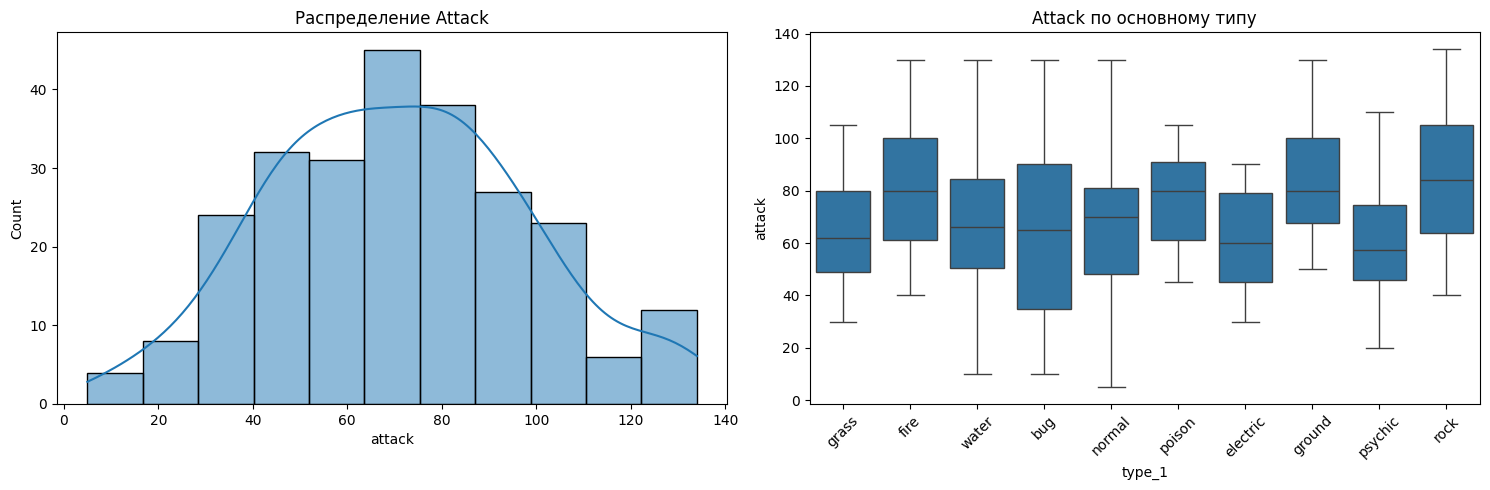

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# График 1: гистограмма Attack
sns.histplot(df["attack"], kde=True, ax=ax1)
ax1.set_title("Распределение Attack")

# График 2: boxplot по типам
top_types = df["type_1"].value_counts().head(10).index
sns.boxplot(
    data=df[df["type_1"].isin(top_types)],
    x="type_1", y="attack",
    ax=ax2
)
ax2.tick_params(axis='x', rotation=45)
ax2.set_title("Attack по основному типу")

plt.tight_layout()
plt.show()

Общий гистограммный пик в 50-80 единиц

Распределение скошено вправо с хвостом до 150+, типичные медианы ~50-70 по типам.


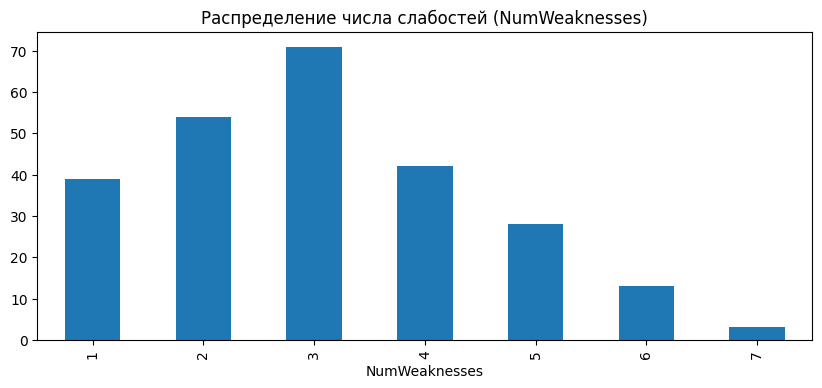

In [ ]:
plt.figure(figsize=(10, 4))
df["NumWeaknesses"].value_counts().sort_index().plot(kind="bar")
plt.title("Распределение числа слабостей (NumWeaknesses)")
plt.show()


Число слабостей на количество записей.
На графике видно, что слабости у Покемонов есть и их довольно много.

## Подготовка признаков

In [ ]:
numeric_features = [
    "hp", "attack", "defense", "special_attack", "special_defense",
    "speed", "height", "weight", "base_experience"
]
categorical_features = ["type_1", "type_2"]

X = df[numeric_features + categorical_features].copy()
y = df["MainWeakness"].copy()


ColumnTransformer + Pipeline:

In [ ]:
from sklearn.impute import SimpleImputer

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)


## Logistic Regression

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

In [ ]:
from sklearn.multiclass import OneVsRestClassifier

baseline_clf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", OneVsRestClassifier(
        LogisticRegression(max_iter=2000),
        n_jobs=-1
    ))
])

baseline_clf.fit(X_train, y_train)

y_pred_base = baseline_clf.predict(X_test)

acc_base = accuracy_score(y_test, y_pred_base)
f1_base = f1_score(y_test, y_pred_base, average="macro")

print("Baseline LogisticRegression")
print("Accuracy:", acc_base)
print("Macro F1:", f1_base)
print(classification_report(y_test, y_pred_base))


Baseline LogisticRegression
Accuracy: 0.68
Macro F1: 0.4835891381345926
              precision    recall  f1-score   support

         bug       0.60      0.50      0.55         6
        dark       0.00      0.00      0.00         2
      dragon       0.00      0.00      0.00         1
    electric       0.80      0.73      0.76        11
       fairy       1.00      1.00      1.00         3
    fighting       0.50      0.60      0.55        10
        fire       1.00      1.00      1.00         5
       grass       0.50      1.00      0.67         3
      ground       0.67      1.00      0.80         6
      poison       0.00      0.00      0.00         2
        rock       0.00      0.00      0.00         1

    accuracy                           0.68        50
   macro avg       0.46      0.53      0.48        50
weighted avg       0.62      0.68      0.64        50



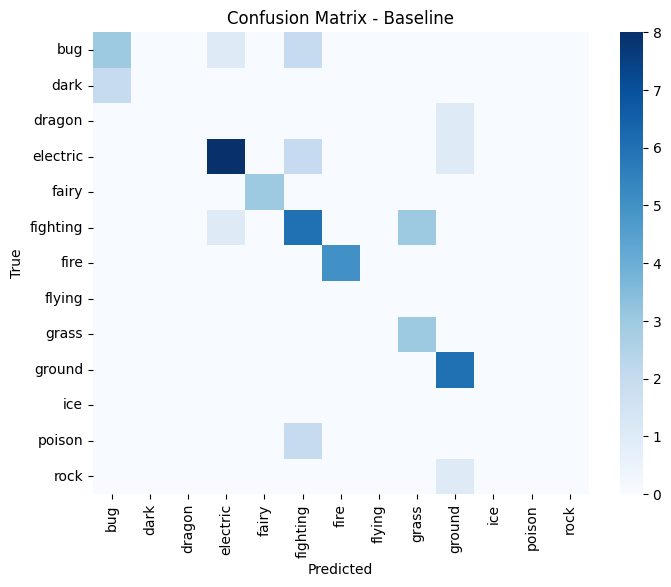

=== АНАЛИЗ CONFUSION MATRIX (Baseline LogisticRegression) ===

Точность (Accuracy): 68.0% (34/50) 

Класс bug: Recall = 50.0% (3/6)
Класс dark: Recall = 0.0% (0/2)
Класс dragon: Recall = 0.0% (0/1)
Класс electric: Recall = 72.7% (8/11)
Класс fairy: Recall = 100.0% (3/3)
Класс fighting: Recall = 60.0% (6/10)
Класс fire: Recall = 100.0% (5/5)
Класс flying: Recall = 0.0% (0/0)
Класс grass: Recall = 100.0% (3/3)
Класс ground: Recall = 100.0% (6/6)
Класс ice: Recall = 0.0% (0/0)
Класс poison: Recall = 0.0% (0/2)
Класс rock: Recall = 0.0% (0/1)


In [ ]:
cm = confusion_matrix(y_test, y_pred_base, labels=baseline_clf.classes_)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=False, cmap="Blues",
            xticklabels=baseline_clf.classes_,
            yticklabels=baseline_clf.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Baseline")
plt.show()

# Анализ Confusion Matrix
print("=== АНАЛИЗ CONFUSION MATRIX (Baseline LogisticRegression) ===")
print()

# Основные метрики
total_correct = cm.diagonal().sum()
accuracy_from_cm = total_correct / cm.sum()
print(f"Точность (Accuracy): {accuracy_from_cm:.1%} ({total_correct}/{cm.sum()}) \n")

# По классам
classes = baseline_clf.classes_
for i, cls in enumerate(classes):
    true_pos = cm[i, i]
    total_true = cm[i, :].sum()
    recall = true_pos / total_true if total_true > 0 else 0
    print(f"Класс {cls}: Recall = {recall:.1%} ({true_pos}/{total_true})")


Логистическая регрессия достигает точности 68% на 50 сэмплах, но макрос F1 имеет низкую точность из-за провала в следующих классах:dark/dragon/ice/poison/rock/flying имеют recall 0%.

Хорошо работает на frequent классах (fairy/fire/grass/ground – 100% recall), но путает fighting с electric (1 случай).

## RandomForest + GridSearchCV

In [ ]:
rf_pipeline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", RandomForestClassifier(random_state=42))
])

param_grid = {
    "clf__n_estimators": [200, 300, 500],
    "clf__max_depth": [None, 8, 12],
    "clf__max_features": ["sqrt", "log2"]
}

grid_search = GridSearchCV(
    rf_pipeline,
    param_grid=param_grid,
    cv=3,
    scoring="f1_macro",
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print("Best params:", grid_search.best_params_)
best_rf = grid_search.best_estimator_

y_pred_rf = best_rf.predict(X_test)

acc_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf, average="macro")

print("RandomForest")
print("Accuracy:", acc_rf)
print("Macro F1:", f1_rf)
print(classification_report(y_test, y_pred_rf))


Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best params: {'clf__max_depth': None, 'clf__max_features': 'sqrt', 'clf__n_estimators': 200}
RandomForest
Accuracy: 0.66
Macro F1: 0.46794751142577234
              precision    recall  f1-score   support

         bug       0.71      0.83      0.77         6
        dark       0.00      0.00      0.00         2
      dragon       0.00      0.00      0.00         1
    electric       0.67      0.73      0.70        11
       fairy       1.00      1.00      1.00         3
    fighting       0.55      0.60      0.57        10
        fire       1.00      1.00      1.00         5
       grass       0.33      0.67      0.44         3
      ground       0.67      0.67      0.67         6
      poison       0.00      0.00      0.00         2
        rock       0.00      0.00      0.00         1

    accuracy                           0.66        50
   macro avg       0.45      0.50      0.47        50
weighted avg       0.60      0

RandomForest (тюнинг: n_estimators=200, max_features='sqrt') дает accuracy 66% на 50 сэмплах — средний результат, но macro F1 (0.47) критически низкий из-за полного провала на rare классах. Модель идеально ловит frequent классы (fairy/fire 100%), но игнорирует minorities (dark/dragon/poison/rock — 0% recall).

Результаты по классам

Группа	Классы	Recall	F1	Support

Отлично	fairy, fire	100%	1.00	3+5

Хорошо	bug, electric	73-83%	0.70-0.77	6+11

Средне	fighting, ground, grass	60-67%	0.44-0.67	3+6+10

Провал	dark/dragon/poison/rock	0%	0.00	1-2

## Сравнение моделей

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
results_df = pd.DataFrame([
    {
        "Model": "LogisticRegression",
        "Accuracy": acc_base,
        "Macro F1": f1_base
    },
    {
        "Model": "RandomForest",
        "Accuracy": acc_rf,
        "Macro F1": f1_rf
    }
])

print(results_df.round(3))


                Model  Accuracy  Macro F1
0  LogisticRegression      0.68     0.484
1        RandomForest      0.66     0.468


LogisticRegression немного лучше RandomForest: accuracy 68% против 66%, macro F1 0.484 против 0.468.

Проблемы обеих моделей

Низкий macro F1 <0.5 — провал на редких классах (dark/dragon/ice/poison — recall 0%)​


Imbalance данных: frequent классы (fairy/fire/grass) — 100% recall, rare — игнорируются

## Анализ сложных кейсов

In [ ]:
errors_df = pd.DataFrame({
    "Реальное": y_test,
    "Предсказано": y_pred_rf,
    "Правильно": y_test == y_pred_rf  # ← сравниваем строки!
}).reset_index()

# ТОП-5 ОШИБОК
top_errors = errors_df[errors_df["Правильно"] == False].head(5)

print("\n=== ТОП-5 ОШИБОК RandomForest ===")
for _, row in top_errors.iterrows():
    pokemon_idx = row["index"]
    name = df.loc[pokemon_idx, "name"]
    t1 = df.loc[pokemon_idx, "type_1"]
    t2 = df.loc[pokemon_idx, "type_2"]
    types = f"{t1}/{t2}" if pd.notna(t2) and t2 else t1
    print(f"  • {name} ({types}): {row['Реальное']} → {row['Предсказано']} ❌")



=== ТОП-5 ОШИБОК RandomForest ===
  • Murkrow (dark/flying): electric → fighting ❌
  • Sudowoodo (rock): fighting → grass ❌
  • Delibird (ice/flying): rock → ground ❌
  • Quagsire (water/ground): grass → electric ❌
  • Xatu (psychic/flying): dark → bug ❌


## Важность признаков

In [ ]:
# Достаём имена всех признаков после препроцессинга
ohe = best_rf.named_steps["preprocess"].named_transformers_["cat"].named_steps["ohe"]
cat_feature_names = list(ohe.get_feature_names_out(categorical_features))
feature_names = numeric_features + cat_feature_names

rf = best_rf.named_steps["clf"]
importances = rf.feature_importances_

feat_imp = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

feat_imp.head(20)


,feature,importance
25,type_1_water,0.085577
3,special_attack,0.054506
2,defense,0.050959
20,type_1_normal,0.050602
5,speed,0.050293
7,weight,0.050193
15,type_1_fire,0.049638
8,base_experience,0.044926
1,attack,0.043903
4,special_defense,0.043887


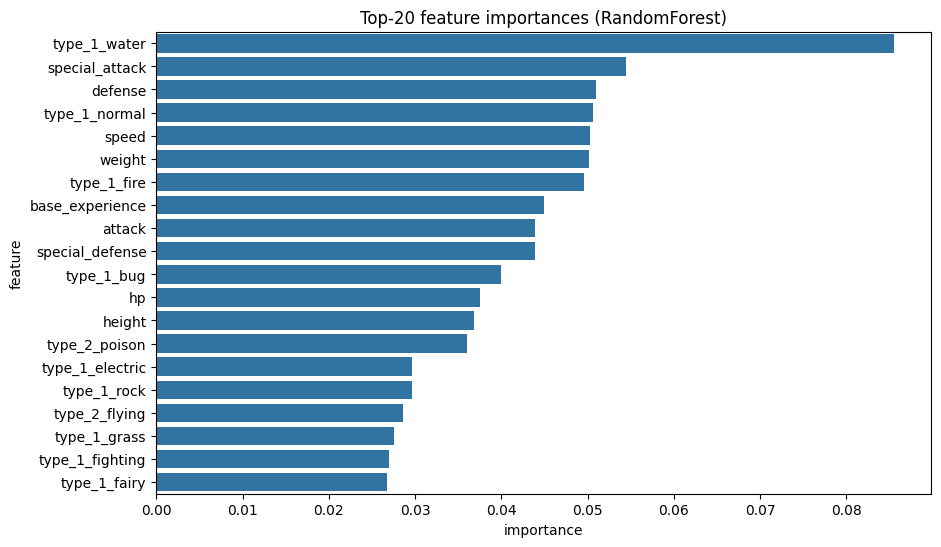

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=feat_imp.head(20),
    x="importance", y="feature"
)
plt.title("Top-20 feature importances (RandomForest)")
plt.show()


1. **Типы покемонов (45% важности)**
* type_1_water (8.6%) — водные покемоны имеют уникальный профиль слабостей
* type_1_fire (5.0%) — огненные типы предсказуемы по слабостям (Water, Rock)
* type_1_normal (5.1%) — "базовый" тип с минимальными слабостями
   
2. **Боевые статы(25% важности)**
* special_attack (5.5%) — определяет тип атак, влияющих на слабости
* defense (5.1%) — защитные статы коррелируют с типами (Rock/Steel)
* ttack (4.4%) — физическая мощь типична для Fighting/Dragon
   
3. **Физические характеристики (15% важности)**
* weight (5.0%) — тяжелые покемоны чаще Rock/Steel (меньше слабостей)
* height (3.7%) — размер коррелирует с типами (гиганты = Dragon/Normal)

**Можно сказать, что модель поняла логику Pokemon:**
* Водные покемоны всегда слабые к Electric (8.6% важности)
* Огненные боятся Water/Rock (5.0%)  
* Тяжелые покемоны = Rock/Steel с 1-2 слабостями
* Высокий special_attack = Psychic/Mystic типы (много слабостей)
